<a href="https://colab.research.google.com/github/hanbiphyun/ESSA_YB/blob/main/ESAA_YB_week6_%EB%B6%84%EB%A5%98_%ED%95%84%EC%82%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**03. 앙상블 학습**
**앙상블 학습 개요**
: 여러 개의 분류기(classifier)를 생성하고 그 예측을 결합하여 정확한 최종 예측을 도출하는 기법.
- 정형 데이터의 분류 시 뛰어난 성능 보임
- 대표 알고리즘 : 랜덤포레스트, 그래디언트 부스팅 알고리즘 + XGBoost, LightGBM
- 학습 유형 -> 보팅(voting), 배깅(bagging), 부스팅(Boosting)
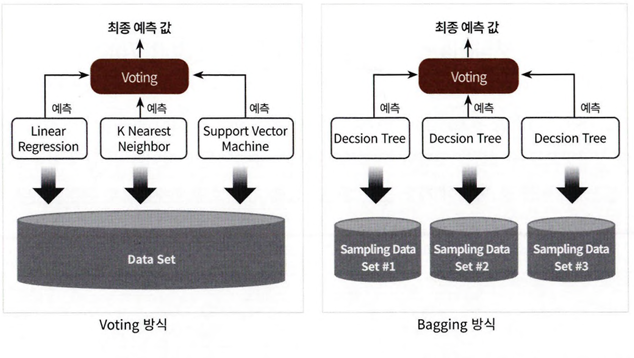
- 대표적인 배깅 방식 = 랜덤 포레스트 알고리즘
- (배깅) 개별 classifier에게 데이터 샘플링해서 추출하는 방식 = 부트스트래핑 분할, 데이터 내 중복 허용

- 부스팅 : 여러 개의 분류기가 순차 학습 수행, 다음 분류기에게 가중치를 부여함
  - 대표 모듈 : 그래디언트 부스트, XGBoost, LightGBM
- 스태킹 : 여러 가지 다른 모델의 예측 결괏값을 학습 데이터로 만들어 다른 모델(메타 모델)로 재학습시켜 결과 예측

**보팅 유형 - 하드 보팅, 소프트 보팅**
- 하드 보팅 : 다수결 원칙같음
- 소프트 보팅 : 분류기들의 레이블 값 결정 확률을 모두 더해 평균내어 확률이 가장 높은 레이블 값을 결괏값으로 선정 -> 일반적
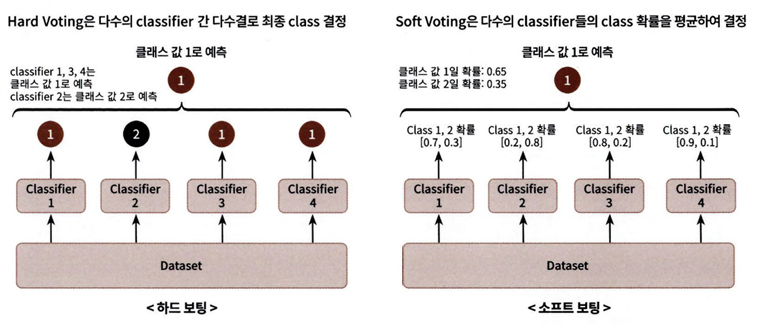
- 보팅 분류기 : VotingClassifier 클래스

In [7]:
#로지스틱 회귀와 KNN기반 보팅 분류기
import pandas as pd

from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer = load_breast_cancer()

data_df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
data_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758


In [8]:
# 개별 모델은 로지스틱 회귀와 KNN임
lr_clf =LogisticRegression()
knn_clf= KNeighborsClassifier(n_neighbors=8)

# 개별 모델을 소프트 보팅 기반의 앙상블 모델로 구현한 분류기
# 주요 생성인자로 estimators와 voting값 입력받기
vo_clf= VotingClassifier(estimators=[('LR', lr_clf), ('KNN', knn_clf)], voting='soft')

X_train, X_test, y_train, y_test= train_test_split(cancer.data, cancer.target,
                                                   test_size=0.2, random_state=156)

# VotingClassifier 학습/예측/평가
vo_clf.fit(X_train, y_train)
pred=vo_clf.predict(X_test)
print('Voting 분류기 정확도: {0:.4f}'.format(accuracy_score(y_test, pred)))

# 개별 모델의 학습/예측/평가
classifiers=[lr_clf, knn_clf]
for classifier in classifiers:
    classifier.fit(X_train, y_train)
    pred=classifier.predict(X_test)
    class_name=classifier.__class__.__name__
    print('{0} 정확도: {1:.4f}'.format(class_name, accuracy_score(y_test, pred)))

Voting 분류기 정확도: 0.9474
LogisticRegression 정확도: 0.9386
KNeighborsClassifier 정확도: 0.9386


###**04. 랜덤 포레스트**
- 배깅의 대표적인 알고리즘
- 여러 개의 결정 트리 분류기- 전체 데이터에서 배깅 방식으로 데이터 샘플링하여 개별 학습 수행 -> 최종적으로 보팅을 통해 예측 결정 *샘플링은 부트스트래핑으로*
- RandomForestClassifier 클래스 이용

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

def get_new_feature_name_df(old_feature_name_df):

    feature_dup_df=pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(), columns=['dup_cnt'])

    feature_dup_df=feature_dup_df.reset_index()

    new_feature_name_df=pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')

    new_feature_name_df['column_name']=new_feature_name_df[['column_name','dup_cnt']].apply(lambda x: x[0]+'_'+str(x[1]) if x[1]>0 else x[0], axis=1)

    new_feature_name_df=new_feature_name_df.drop(['index'], axis=1)

    return new_feature_name_df

def get_human_dataset():

    feature_name_df = pd.read_csv('/content/features.txt', sep='\s+',

                                  header=None, names=['column_index', 'column_name'])

    new_feature_name_df = get_new_feature_name_df(feature_name_df)

    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()

    X_train = pd.read_csv('/content/X_train.txt', sep='\s+', names=feature_name)

    X_test = pd.read_csv('/content/X_test.txt', sep='\s+', names=feature_name)

    y_train = pd.read_csv('/content/y_train.txt', sep='\s+', header=None, names=['action'])

    y_test = pd.read_csv('/content/y_test.txt', sep='\s+', header=None, names=['action'])

    return X_train, X_test, y_train, y_test

X_train,X_test,y_train,y_test=get_human_dataset()

#결정 트리에서 사용한 get_human_dataset()을 이용해 학습/ 테스트용 DataFrame 반환
X_train, X_test, y_train, y_test=get_human_dataset()

#랜덤 포레스트 학습 및 별도의 테스트 세트로 예측 성능 평가
rf_clf=RandomForestClassifier(random_state=0, max_depth=8)
rf_clf.fit(X_train, y_train)
pred=rf_clf.predict(X_test)
accuracy=accuracy_score(y_test, pred)
print('랜덤 포레스트 정확도: {0:.4f}'.format(accuracy))

랜덤 포레스트 정확도: 0.9220


**랜덤 포레스트 하이퍼 파라미터 및 튜닝**
- n_estimators : 결정 트리 개수 지정, 디폴트 10개
- max_features : 피처 참조 개수, 디폴트 sqrt


In [9]:
from sklearn.model_selection import GridSearchCV

params= {
    'max_depth':[8,16,24],
    'min_samples_leaf':[1,6,12],
    'min_samples_split':[2,8,16]
}
# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf=RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
grid_cv=GridSearchCV(rf_clf, param_grid=params, cv=2, n_jobs=-1)
grid_cv.fit(X_train, y_train)

print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

최적 하이퍼 파라미터:
 {'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 2}
최고 예측 정확도: 0.9627


In [5]:
rf_clf1=RandomForestClassifier(n_estimators=500, random_state=0, verbose=1, n_jobs=-1,
                                max_depth=16, min_samples_leaf=6, min_samples_split=2)
rf_clf.fit(X_train, y_train)
pred=rf_clf.predict(X_test)
print('예측 정확도: {0:.4f}'.format(accuracy_score(y_test, pred)))


예측 정확도: 0.9223


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importances_values=rf_clf1.feature_importances_
ftr_importances=pd.Series(ftr_importances_values, index=X_train.columns)
ftr_top20=ftr_importances.sort_values(ascending=False)[:20]
plt.figure(figsize=(8,6))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()

###**05.GBM(Gradient Boosting Machine)**
- 부스팅 알고리즘은 여러 개의 약한 학습기를 순차적으로 학습-예측하면서 잘못 예측한 데이터에 가중치 부여함

*AdaBoost 예시*
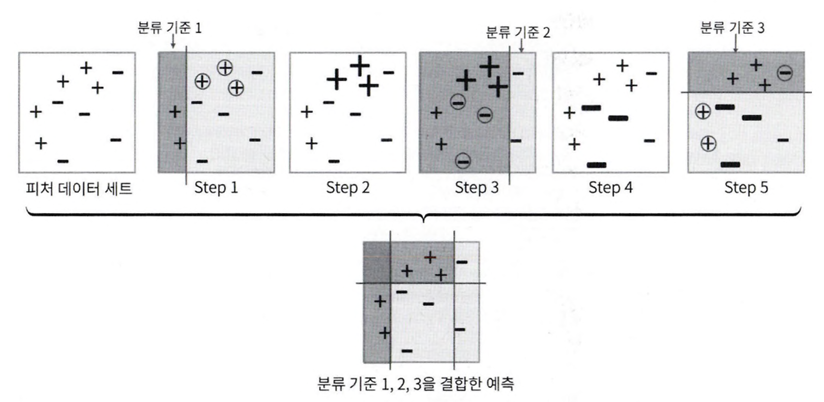

- GBM : 가중치 업데이트를 경사하강법을 이용함
  - 경사하강법 : 분류의 실제 결괏값을y, 피처를 x1,...,xR 그리고 이 피처에 기반한 예측 함수를F(x) 함수라고 하면 오류식
h(x) = y - F(x) 이 됩니다. 이 오류식 h(x) =y - F(x)를 최소화하는 방향성을 가지고 반복적으로 가중치 값을 업데이트하는 것
- 회귀도 가능함
- GradientBoostingClassifier 클래스

In [4]:
from sklearn.ensemble import GradientBoostingClassifier
import time
import warnings
warnings.filterwarnings('ignore')

X_train, x_test, y_train, y_test = get_human_dataset()

#GBM 수행 시간 측정을 위함. 시작 시간 설정
start_time = time.time()
gb_clf = GradientBoostingClassifier(random_state=0)
gb_clf.fit(X_train, y_train)
gb_pred = gb_clf.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)

print('GBM 정확도 : {0: .4f}'.format(gb_accuracy))
print('GBM 수행 시간 : {0: .1f}초'.format(time.time() - start_time))

GBM 정확도 :  0.9379
GBM 수행 시간 :  1841.8초


###**XGBoost**
- 파라미터
  - booster
  - silent
  - nthread
- 부스터 파라미터
  - eta [default=0.3, alias: learning_rate] : 부스팅 스텝을 반복적으로 수행할때 업데이트되는 학습률 값
  - num_boost_rounds
  - min_child_weight
  - gamma : 최소 손실 감소 값
  - max_depth
  - sub_sample
  - colsample_bytree
  - lambda : L2 정규화 적용 값
  - alpha : L1 정규화 적용 값
  - scale_pos_weight
- 학습 태스크 파라미터
  - objective (목적함수)
  - binary:logistic: (이진 로지스틱)
  - multi:softmax:
  - eval_metric

**과적합 심각할 때 고려할 것**
- eta낮추기
- max_depth 낮추기
- min_child_weight 높이기
- gamma 높이기

++
XGBoost, LightGBM - 조기중단 기능 있음

In [5]:
import xgboost as xgb
from xgboost import XGBClassifier



In [10]:
import xgboost
print(xgboost.__version__)

3.0.5


In [12]:
import xgboost as xgb
from xgboost import plot_importance
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

dataset= load_breast_cancer()
features= dataset.data
labels= dataset.target

cancer_df= pd.DataFrame(data=features, columns=dataset.feature_names)
cancer_df['target']=labels
cancer_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0


In [13]:
print(dataset.target_names)
print(cancer_df['target'].value_counts)

['malignant' 'benign']
<bound method IndexOpsMixin.value_counts of 0      0
1      0
2      0
3      0
4      0
      ..
564    0
565    0
566    0
567    0
568    1
Name: target, Length: 569, dtype: int64>


In [14]:
#cancer_df에서 feature용 DataFrame과 Label용 Series 객체 추출
# 맨 마지막 칼럼이 Label임. Feature용 DataFrame은 cancer_df의 첫번째 칼럼에서 맨 마지막 두번째 칼럼까지를 :-1 슬라이싱으로 추출
X_features= cancer_df.iloc[:,:-1]
y_label= cancer_df.iloc[:,-1]

#전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test= train_test_split(X_features, y_label, test_size=0.2, random_state=156)

#위에서 만든 X_train, y_train을 다시 쪼개서 90%는 학습과 10%는 검증용 데이터로 분리
X_tr, X_val, y_tr, y_val= train_test_split(X_train, y_train, test_size=0.1, random_state=156)

print(X_train.shape, X_test.shape)
print(X_tr.shape, X_val.shape)

(455, 30) (114, 30)
(409, 30) (46, 30)


In [15]:
#만약 구버전 XGBoost에서 DataFrame으로 DMatrix 생성이 안 될 경우, X_train.values로 넘파이 변환
#학습, 검증, 테스트용 DMatrix를 생성
dtr= xgb.DMatrix(data=X_tr, label=y_tr)
dval= xgb.DMatrix(data=X_val, label=y_val)
dtest= xgb.DMatrix(data=X_test, label=y_test)

- 오류 함수의 평가 성능 지표 = logloss

In [16]:
params={
    'max_depth':3,
    'eta':0.05,
    'objective':'binary:logistic',
    'eval_metric':'logloss'
}
num_rounds=400

#지정된 하이퍼 파라미터로 XGBoost모델 학습하기

In [17]:
# 학습 데이터 셋은 'train' 또는 평가 데이터 셋은 'eval'로 명기합니다.
eval_list=[(dtr,'train'),(dval,'eval')] # 또는 eval_list=[(dval,'eval)] 만 명기해도 무방.

#하이퍼 파라미터와 early stopping 파라미터를 train() 함수의 파라미터로 전달
xgb_model= xgb.train(params= params, dtrain=dtr, num_boost_round=num_rounds,
                     early_stopping_rounds=50, evals=eval_list)

[0]	train-logloss:0.62473	eval-logloss:0.63088
[1]	train-logloss:0.58662	eval-logloss:0.60461
[2]	train-logloss:0.55210	eval-logloss:0.58205
[3]	train-logloss:0.52068	eval-logloss:0.56165
[4]	train-logloss:0.49173	eval-logloss:0.54101
[5]	train-logloss:0.46517	eval-logloss:0.52206
[6]	train-logloss:0.44009	eval-logloss:0.50271
[7]	train-logloss:0.41646	eval-logloss:0.48606
[8]	train-logloss:0.39505	eval-logloss:0.46961
[9]	train-logloss:0.37523	eval-logloss:0.45485
[10]	train-logloss:0.35682	eval-logloss:0.44120
[11]	train-logloss:0.33964	eval-logloss:0.43123
[12]	train-logloss:0.32279	eval-logloss:0.41962
[13]	train-logloss:0.30783	eval-logloss:0.40848
[14]	train-logloss:0.29308	eval-logloss:0.39857
[15]	train-logloss:0.27928	eval-logloss:0.38945
[16]	train-logloss:0.26681	eval-logloss:0.38171
[17]	train-logloss:0.25498	eval-logloss:0.37381
[18]	train-logloss:0.24352	eval-logloss:0.36656
[19]	train-logloss:0.23307	eval-logloss:0.36014
[20]	train-logloss:0.22290	eval-logloss:0.35395
[2

In [19]:
#xgboost 이용해 모델 학습 완료후, 테스트 데이터 세트에 예측 수행
#여기서 predict() 메서드는 예측 결과를 추정할수있는 확률 값 반환

pred_probs= xgb_model.predict(dtest)
print('predict() 수행 결괏값을 10개만 표시, 예측 확률값으로 표시됨')
print(np.round(pred_probs[:10],3))

#예측 확률이 0.5보다 크면 1, 그렇지 않으면 0으로 예측값 결정하여 List 객체인 preds에 저장
preds= [1 if x>0.5 else 0 for x in pred_probs]
print('예측값 10개만 표시:', preds[:10])

predict() 수행 결괏값을 10개만 표시, 예측 확률값으로 표시됨
[0.938 0.004 0.776 0.058 0.975 1.    0.999 0.999 0.998 0.   ]
예측값 10개만 표시: [1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


In [21]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def get_clf_eval(y_test, pred, pred_proba):

    confusion=confusion_matrix(y_test,pred)

    accuracy=accuracy_score(y_test, pred)

    precision=precision_score(y_test, pred)

    recall=recall_score(y_test,pred)

    f1=f1_score(y_test, pred)

    roc_auc=roc_auc_score(y_test,pred)

    print('오차행렬')

    print(confusion)

    print('정확도:{0:.4f},정밀도:{1:.4f},재현율:{2:.4f},F1:{3:.4f}, AUC:{4:.4f}'.format(accuracy,precision,recall,f1,roc_auc))

get_clf_eval(y_test, preds, pred_probs)

오차행렬
[[35  2]
 [ 2 75]]
정확도:0.9649,정밀도:0.9740,재현율:0.9740,F1:0.9740, AUC:0.9600


<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

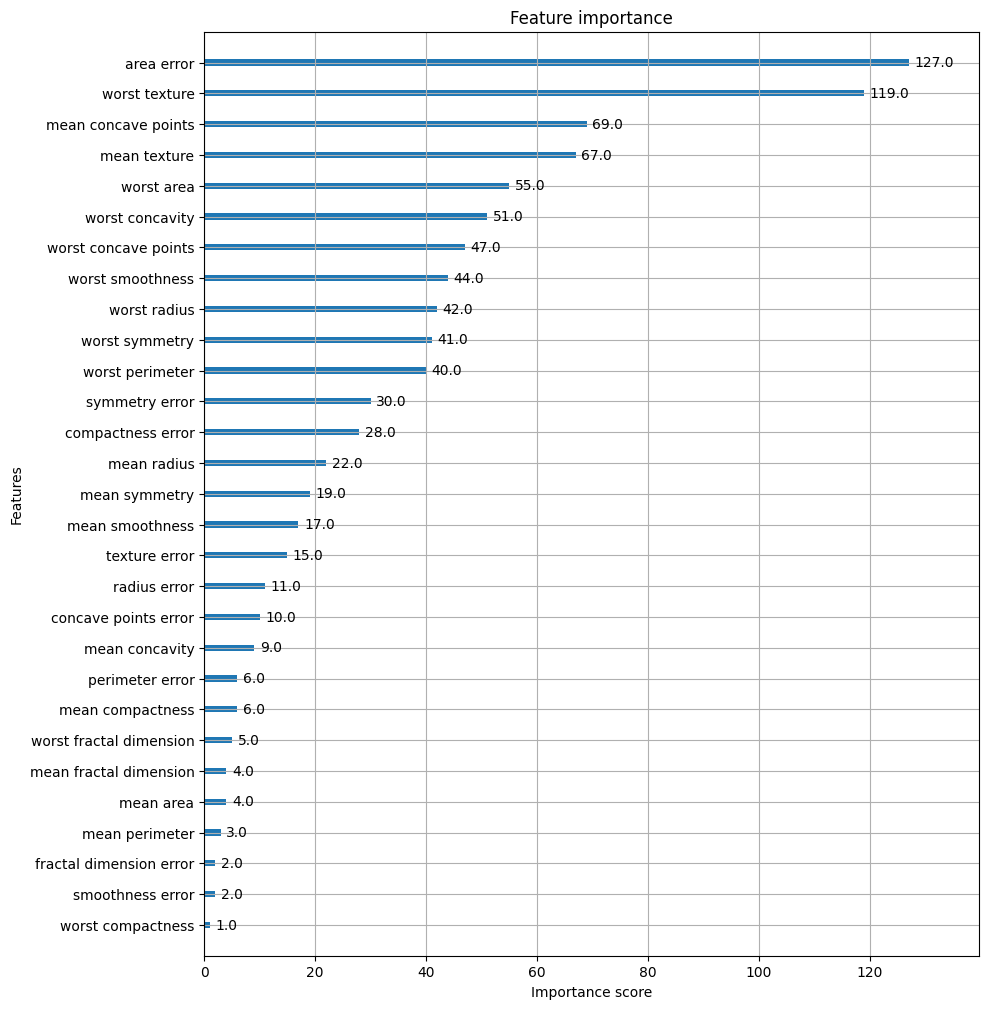

In [22]:
#시각화 기능 수행 - plot_importance() API 사용
#넘파이에서 피처명을 알 수 없으면 Y축의 피처명을 f0, f1같이 피처명 나타냄
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax= plt.subplots(figsize=(10,12))
plot_importance(xgb_model, ax=ax)

> xgboost.cv(params, dtrain, num_boost_ro나nd=10, nfold=3, stratified=False, folds=Nonez metrics=(),
obj=None, feval=None, maximize=False, early_stopping_rounds=Non은, fpreproc=None, as_pandas=True,
verbose_eval=None, show_stdv=True, seed=Gz callbacks=None, shuffle=True)
- params : 부스터 파라미터
- dtrain : 학습 데이터
- num_boost_round : 부스팅 반복 횟수
- nfold : CV 폴드 개수
- stratified : 층화 표본 추출 수행 여부
- metrics : 성능 평가 지표
- early_stopping_rounds : 조기 중단 활성화

**사이킷런 래퍼 XGBoost 개요 및 적용**
- fit(), predict()만으로 학습, 예측 가능
- 분류를 위한 래퍼 클래스 XGBClassifier, 회귀를 위한 XGBRegressor

 ■ eta — learning_rate

 ■ sub_sample — subsample

 ■ lambda — regjambda

 ■ alpha — reg_alpha

In [23]:
# 사이킷런 래퍼 XGBoost 클래스인 XGBClassifier 임포트
from xgboost import XGBClassifier

#Warning 메시지를 없애기 위해 eval_metric 값을 XGBClassifier 생성 인자로 입력
xgb_wrapper= XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3, eval_metric='logloss')
xgb_wrapper.fit(X_train, y_train,verbose=True)
w_preds= xgb_wrapper.predict(X_test)
w_pred_proba= xgb_wrapper.predict_proba(X_test)[:,1]

get_clf_eval(y_test, w_preds, w_pred_proba)

오차행렬
[[35  2]
 [ 1 76]]
정확도:0.9737,정밀도:0.9744,재현율:0.9870,F1:0.9806, AUC:0.9665


In [30]:
import xgboost as xgb
from xgboost import XGBClassifier

xgb_wrapper=XGBClassifier(n_estimators=400, learning_rate=0.05, max_depth=3, early_stopping_rounds=50, eval_metric='logloss')
evals=[(X_tr,y_tr),(X_val,y_val)]
xgb_wrapper.fit(X_tr,y_tr, eval_set=evals, verbose=True)

ws50_preds= xgb_wrapper.predict(X_test)
ws50_pred_proba= xgb_wrapper.predict_proba(X_test)[:,1]

[0]	validation_0-logloss:0.62473	validation_1-logloss:0.63088
[1]	validation_0-logloss:0.58662	validation_1-logloss:0.60461
[2]	validation_0-logloss:0.55210	validation_1-logloss:0.58205
[3]	validation_0-logloss:0.52068	validation_1-logloss:0.56165
[4]	validation_0-logloss:0.49173	validation_1-logloss:0.54101
[5]	validation_0-logloss:0.46517	validation_1-logloss:0.52206
[6]	validation_0-logloss:0.44009	validation_1-logloss:0.50271
[7]	validation_0-logloss:0.41646	validation_1-logloss:0.48606
[8]	validation_0-logloss:0.39505	validation_1-logloss:0.46961
[9]	validation_0-logloss:0.37523	validation_1-logloss:0.45485
[10]	validation_0-logloss:0.35682	validation_1-logloss:0.44120
[11]	validation_0-logloss:0.33964	validation_1-logloss:0.43123
[12]	validation_0-logloss:0.32279	validation_1-logloss:0.41962
[13]	validation_0-logloss:0.30783	validation_1-logloss:0.40848
[14]	validation_0-logloss:0.29308	validation_1-logloss:0.39857
[15]	validation_0-logloss:0.27928	validation_1-logloss:0.38945
[1

In [31]:
get_clf_eval(y_test, ws50_preds, ws50_pred_proba)

오차행렬
[[35  2]
 [ 2 75]]
정확도:0.9649,정밀도:0.9740,재현율:0.9740,F1:0.9740, AUC:0.9600


In [32]:
xgb_wrapper=XGBClassifier(n_estimators=400, learning_rate=0.05, max_depth=3, early_stopping_rounds=10, eval_metric='logloss')

xgb_wrapper.fit(X_tr,y_tr, eval_set=evals, verbose=True)

ws10_preds=xgb_wrapper.predict(X_test)

ws10_preds_proba=xgb_wrapper.predict_proba(X_test)[:,1]

get_clf_eval(y_test, ws10_preds, ws10_preds_proba)

[0]	validation_0-logloss:0.62473	validation_1-logloss:0.63088
[1]	validation_0-logloss:0.58662	validation_1-logloss:0.60461
[2]	validation_0-logloss:0.55210	validation_1-logloss:0.58205
[3]	validation_0-logloss:0.52068	validation_1-logloss:0.56165
[4]	validation_0-logloss:0.49173	validation_1-logloss:0.54101
[5]	validation_0-logloss:0.46517	validation_1-logloss:0.52206
[6]	validation_0-logloss:0.44009	validation_1-logloss:0.50271
[7]	validation_0-logloss:0.41646	validation_1-logloss:0.48606
[8]	validation_0-logloss:0.39505	validation_1-logloss:0.46961
[9]	validation_0-logloss:0.37523	validation_1-logloss:0.45485
[10]	validation_0-logloss:0.35682	validation_1-logloss:0.44120
[11]	validation_0-logloss:0.33964	validation_1-logloss:0.43123
[12]	validation_0-logloss:0.32279	validation_1-logloss:0.41962
[13]	validation_0-logloss:0.30783	validation_1-logloss:0.40848
[14]	validation_0-logloss:0.29308	validation_1-logloss:0.39857
[15]	validation_0-logloss:0.27928	validation_1-logloss:0.38945
[1

- 88회까지 반복 후 학습 종료 -> 성능 평가 지수가 향상되지 못해서

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

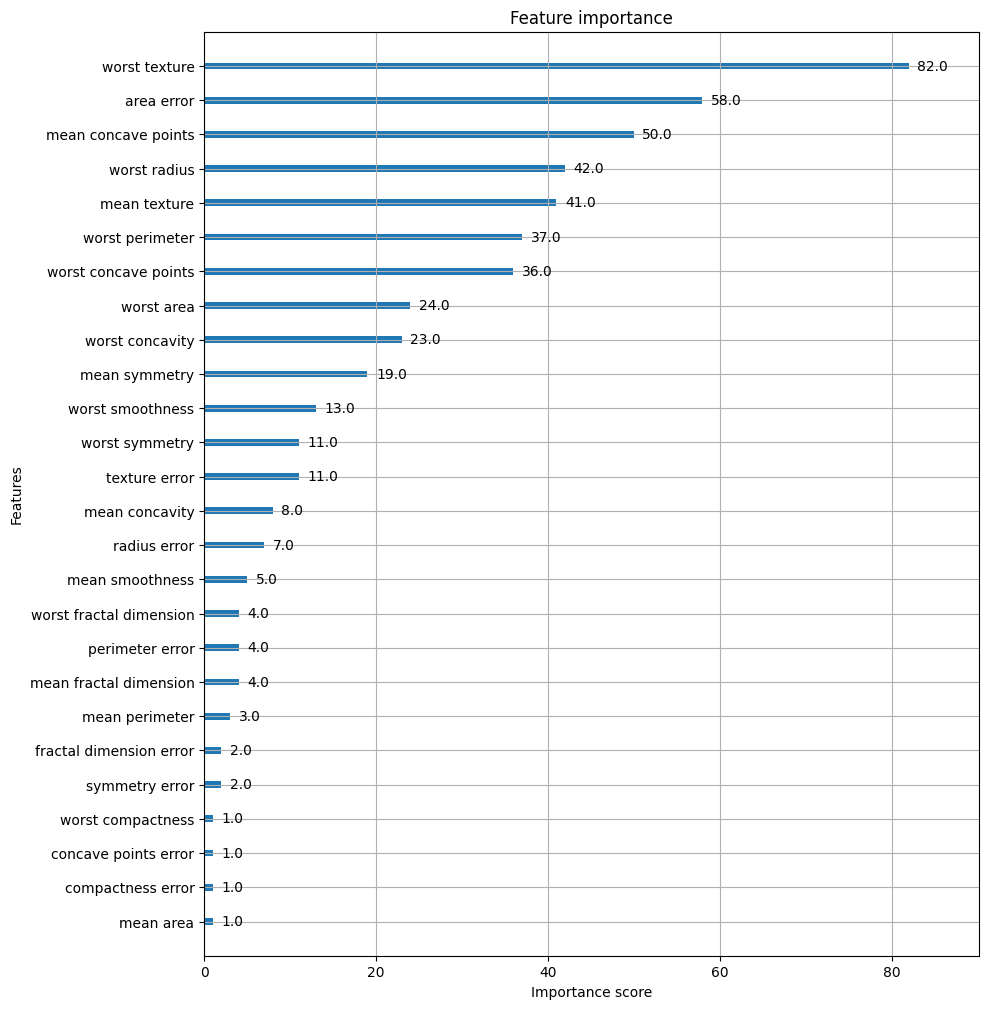

In [35]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax= plt.subplots(figsize=(10,12))
#사이킷런 래퍼 클래스를 입력해도 무방
plot_importance(xgb_wrapper, ax=ax)